In [1]:
#import jax.numpy as np
#from jax import pmap
import numpy as np
from maxnorm.maxnorm_completion import *
from maxnorm.tenalg import *
from maxnorm.graphs import *
import sparse
from itertools import product

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload

In [2]:
# create random, low-rank tensor
t = 5
n = 50
r = 3
#delta = 0.1
const = 40
sigma = 0.1
ndata =  const * r * t * n * np.log10(n)
U = kr_random(n, t, r)
#U = [np.random.randn(n, r) for i in range(t)]
print("n data: %.2e" % ndata)
print("n data t/2: %.2e" % int(const * r * n**(t/2) * np.log10(n)))

n data: 5.10e+04
n data t/2: 3.60e+06


In [3]:
max_qnorm_ub(U)

549.8670608821482

In [4]:
observation_mask = obs_mask_iid(tuple([n for i in range(t)]), ndata * n**(-t))
data = observation_mask.copy()

clean_data = kr_get_items(U, data.coords)

#clean_data = np.array(list(map(get_item_coords, [data.coords[:, i] for i in range(data.nnz)])))

# for i in range(data.nnz):
#     pred = get_item(U, data.coords[:, i])
#     data.data[i] = pred
# clean_data = data.data

clean_data_rms = np.sqrt(np.sum(clean_data)**2 / len(clean_data))

data.data = clean_data + np.random.randn(data.nnz) * sigma * clean_data_rms
#data.data /= np.sqrt(loss(U, data) / data.nnz)
print(data.nnz)

50969


In [5]:
data.coords

array([[ 0,  0,  0, ..., 49, 49, 49],
       [ 0,  0,  0, ..., 49, 49, 49],
       [ 2,  3, 13, ..., 43, 44, 45],
       [40, 28, 34, ..., 28, 32, 10],
       [18, 41,  1, ..., 23, 10,  1]])

In [6]:
clean_data_rmse = np.sqrt(loss(U, data) / data.nnz)
delta = 2 * clean_data_rmse
#np.sqrt(np.sum((data.data - clean_data)**2)) * 2 / np.sqrt(data.nnz) * 1.5

print("rms of data:        %f" % clean_data_rms)
print("delta parameter:    %f" % delta)
print("rmse of U true:     %f" % np.sqrt(loss(U, data) / data.nnz))

/home/kamdh/local/anaconda3/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  entrypoints.init_all()


rms of data:        0.430687
delta parameter:    0.085868
rmse of U true:     0.042934


In [8]:
# from tensorly.contrib.sparse.decomposition import parafac

# mask = data != 0
# core, factors = parafac(data, r, mask=mask, init='random', verbose=True, tol=1e-3, n_iter_max=8)
# scale_mat = np.diag(core.todense()**(1/t))
# U = [factors[i].todense() @ scale_mat for i in range(t)]

In [9]:
%autoreload
Unew1, cost_arr = tensor_completion_maxnorm(data, r*2, init='alt_min', max_iter=40, tol=1e-6, inner_max_iter=40)

TypeError: tensor_completion_maxnorm() missing 1 required positional argument: 'delta'

In [10]:
max_qnorm_ub(Unew1)

198.25088355139917

In [19]:
%autoreload
Unew2, cost_arr = tensor_completion_maxnorm(data, r*2, delta * np.sqrt(data.nnz), epsilon=0., 
                                            #sgd=True, sgd_batch_size=int(ndata/2),
                                            #U0 = Unew1,
                                            init='svdrand', kappa=100, beta=1, tol=1e-8, max_iter=40, verbosity=1)

Initial cost: 9.439e+06
Initial qnorm_ub: 1.095e+00
|| r || = 2.010e+00, delta = 1.939e+01

finished in 40 iterations


scaled || r || = 1.526e+00, delta = 8.587e-02
Max-qnorm upper bound: 1.215e+04
Cost function:         5.300e+06


In [14]:
#print("loss of U parafac:  %f" % np.sqrt(loss(U,data) / data.nnz))
print("loss of U true:     %.3e" % np.sqrt(loss(U, data) / data.nnz))
#print("loss of U alt-min:  %.3e" % np.sqrt(loss(Unew1, data) / data.nnz))
print("loss of U max:      %.3e" % np.sqrt(loss(Unew2, data) / data.nnz))

loss of U true:     4.293e-02
loss of U max:      2.010e+00


Text(0, 0.5, 'cost')

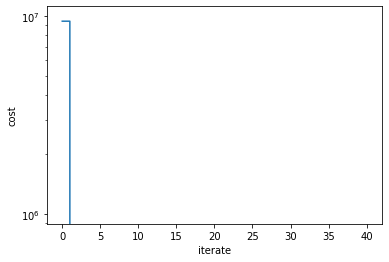

In [15]:
import matplotlib.pyplot as plt

plt.semilogy(cost_arr)
plt.xlabel('iterate')
plt.ylabel('cost')

## Generalization error

In [17]:
def gen_err(Upred, Utrue):
    norm_true = kr_dot(Utrue, Utrue)
    mse_gen = kr_dot(Upred, Upred) + norm_true - 2 * kr_dot(Upred, Utrue)
    return np.sqrt(mse_gen / norm_true)

#print("relative RMSE alt-min:  %1.4e" % np.sqrt(gen_err(Unew1, U)))
print("relative RMSE max:      %1.4e" % np.sqrt(gen_err(Unew2, U)))

relative RMSE max:      1.0000e+00


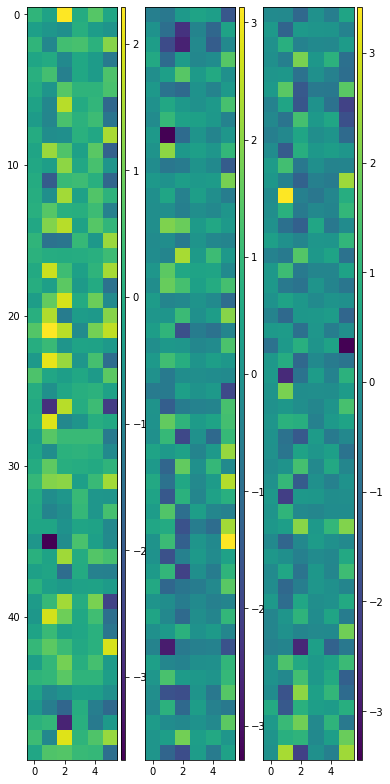

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,t, figsize=(6, 20))
for i in range(t):
    im = axs[i].imshow(Unew2[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:
        axs[i].set_yticks([])

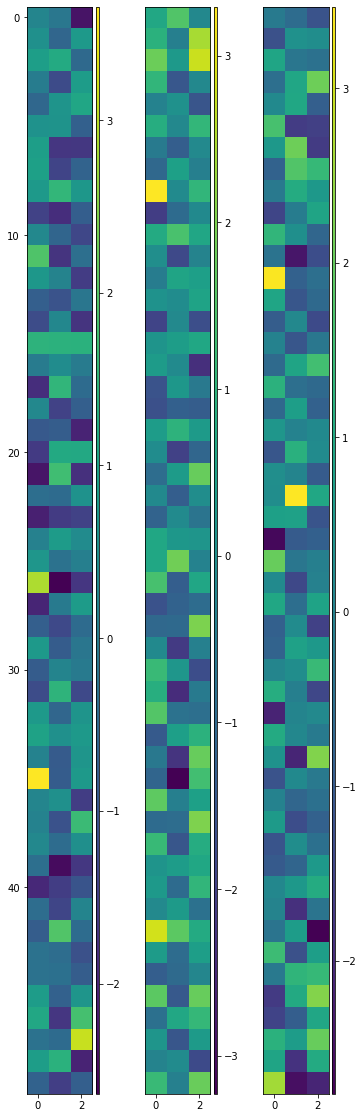

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,t, figsize=(6, 20))
for i in range(t):
    im = axs[i].imshow(U[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:
        axs[i].set_yticks([])

In [52]:
def generate_data(obs_mask, U, sigma):
    data = obs_mask.copy()
    clean_data = kr_get_items(U, data.coords)
    clean_data_rms = np.sqrt(np.sum(clean_data)**2 / len(clean_data))
    data.data = clean_data + np.random.randn(data.nnz) * sigma * clean_data_rms
    return data

def gen_err(Upred, Utrue):
    norm_true = kr_dot(Utrue, Utrue)
    mse_gen = kr_dot(Upred, Upred) + norm_true - 2 * kr_dot(Upred, Utrue)
    return np.sqrt(mse_gen / norm_true)


def run_simulation(n, t, r, sigma, r_fit, rep, const = 10):
    n = int(n)
    t = int(t)
    r = int(r)
    r_fit = int(r_fit)
    rep = int(rep)
    ndata =  const * r * t * n * np.log10(n)
    U = kr_random(n, t, r, rescale=1e3)
    observation_mask = obs_mask_iid(tuple([n for i in range(t)]), ndata * n**(-t))
    data = generate_data(observation_mask, U, sigma)
    clean_data_rmse = np.sqrt(loss(U, data) / data.nnz)
    delta = 2 * clean_data_rmse
    U_fit_als, cost_arr_als = \
      tensor_completion_alt_min(data, r_fit, init='svd', max_iter=40, tol=1e-6, inner_max_iter=40)
    U_fit_max, cost_arr_max = \
      tensor_completion_maxnorm(data, r_fit, delta * np.sqrt(data.nnz), epsilon=1e-1, 
                                    #sgd=True, sgd_batch_size=int(ndata/2),
                                    #U0 = Unew1,
                                    init='svdrand', kappa=10, beta=1, tol=1e-8, max_iter=100)
    loss_true = np.sqrt(loss(U, data) / data.nnz)
    loss_als = np.sqrt(loss(U_fit_als, data) / data.nnz)
    loss_max = np.sqrt(loss(U_fit_max, data) / data.nnz)
    gen_err_als = np.sqrt(gen_err(U_fit_als, U))
    gen_err_max = np.sqrt(gen_err(U_fit_max, U))
    return loss_true, loss_als, loss_max, gen_err_als, gen_err_max

In [22]:
results = run_simulation(n, t, r, sigma, 6*r, 0)

Initial cost: 30840.494451
|| r || = 2.840436

Entering inner loop for factor 0
         Current function value: 30595.095337
         Iterations: 14
         Function evaluations: 93
         Gradient evaluations: 81
Entering inner loop for factor 1
         Current function value: 30076.671450
         Iterations: 40
         Function evaluations: 64
         Gradient evaluations: 64
Entering inner loop for factor 2
         Current function value: 25477.055032
         Iterations: 40
         Function evaluations: 60
         Gradient evaluations: 60

Iteration 0 complete
|| resid || = 2.581222
Cost :         2.548e+04

Entering inner loop for factor 0
         Current function value: 16488.597306
         Iterations: 40
         Function evaluations: 66
         Gradient evaluations: 66
Entering inner loop for factor 1
         Current function value: 9210.917979
         Iterations: 40
         Function evaluations: 60
         Gradient evaluations: 60
Entering inner loop for fact

         Current function value: 166.354931
         Iterations: 40
         Function evaluations: 60
         Gradient evaluations: 60
Entering inner loop for factor 1
         Current function value: 165.124121
         Iterations: 40
         Function evaluations: 64
         Gradient evaluations: 64
Entering inner loop for factor 2
         Current function value: 164.086302
         Iterations: 40
         Function evaluations: 61
         Gradient evaluations: 61

Iteration 10 complete
|| resid || = 0.201159
Cost :         1.641e+02

Entering inner loop for factor 0
         Current function value: 163.106232
         Iterations: 40
         Function evaluations: 63
         Gradient evaluations: 63
Entering inner loop for factor 1
         Current function value: 162.152186
         Iterations: 40
         Function evaluations: 58
         Gradient evaluations: 58
Entering inner loop for factor 2
         Current function value: 161.355590
         Iterations: 40
         Functi

         Current function value: 146.265354
         Iterations: 40
         Function evaluations: 64
         Gradient evaluations: 64
Entering inner loop for factor 2
         Current function value: 145.850624
         Iterations: 40
         Function evaluations: 62
         Gradient evaluations: 62

Iteration 20 complete
|| resid || = 0.189184
Cost :         1.459e+02

Entering inner loop for factor 0
         Current function value: 145.421084
         Iterations: 40
         Function evaluations: 65
         Gradient evaluations: 65
Entering inner loop for factor 1
         Current function value: 144.992912
         Iterations: 40
         Function evaluations: 66
         Gradient evaluations: 66
Entering inner loop for factor 2
         Current function value: 144.648509
         Iterations: 40
         Function evaluations: 60
         Gradient evaluations: 60

Iteration 21 complete
|| resid || = 0.188368
Cost :         1.446e+02

Entering inner loop for factor 0
         Cu

         Current function value: 137.424387
         Iterations: 40
         Function evaluations: 58
         Gradient evaluations: 58

Iteration 30 complete
|| resid || = 0.183400
Cost :         1.374e+02

Entering inner loop for factor 0
         Current function value: 137.218209
         Iterations: 40
         Function evaluations: 58
         Gradient evaluations: 58
Entering inner loop for factor 1
         Current function value: 137.026805
         Iterations: 40
         Function evaluations: 61
         Gradient evaluations: 61
Entering inner loop for factor 2
         Current function value: 136.849205
         Iterations: 40
         Function evaluations: 59
         Gradient evaluations: 59

Iteration 31 complete
|| resid || = 0.183001
Cost :         1.368e+02

Entering inner loop for factor 0
         Current function value: 136.660313
         Iterations: 40
         Function evaluations: 67
         Gradient evaluations: 67
Entering inner loop for factor 1
         Cu

iteration 30, objective 9.890e+04, relative change 6.040e-05        
maximum iteration 30 reached with relative change in objective function 6e-05

Iteration 0 complete


scaled || r || = 2.137062, delta = 0.541361
Max-qnorm upper bound: 311.395769
Cost function:         9.884e+04


Entering inner loop for factor 0
qnorm_factr = 37.128254
initial objective 9.884311e+04
iteration 30, objective 6.183e+04, relative change 7.360e-05        
maximum iteration 30 reached with relative change in objective function 7.4e-05
Entering inner loop for factor 1
qnorm_factr = 46.950181
initial objective 6.183866e+04
iteration 30, objective 3.516e+04, relative change 4.788e-05        
maximum iteration 30 reached with relative change in objective function 4.8e-05
Entering inner loop for factor 2
qnorm_factr = 52.834775
initial objective 3.516180e+04
iteration 30, objective 1.883e+04, relative change 5.105e-05        
maximum iteration 30 reached with relative change in objective function 5.1e-05

Iter

iteration 30, objective 2.509e+02, relative change 4.439e-05        
maximum iteration 30 reached with relative change in objective function 4.4e-05

Iteration 18 complete


scaled || r || = 0.198143, delta = 0.541361
Max-qnorm upper bound: 61.366128
Cost function:         2.510e+02


Entering inner loop for factor 0
qnorm_factr = 16.609487
initial objective 2.509877e+02
iteration 30, objective 2.501e+02, relative change 7.814e-05        
maximum iteration 30 reached with relative change in objective function 7.8e-05
Entering inner loop for factor 1
qnorm_factr = 14.175643
initial objective 2.500738e+02
iteration 30, objective 2.493e+02, relative change 2.500e-05        
maximum iteration 30 reached with relative change in objective function 2.5e-05
Entering inner loop for factor 2
qnorm_factr = 15.855841
initial objective 2.495891e+02
iteration 30, objective 2.488e+02, relative change 4.392e-05        
maximum iteration 30 reached with relative change in objective function 4.4e-05

It

iteration 30, objective 2.290e+02, relative change 2.296e-05        
maximum iteration 30 reached with relative change in objective function 2.3e-05

Iteration 36 complete


scaled || r || = 0.185571, delta = 0.541361
Max-qnorm upper bound: 56.833485
Cost function:         2.291e+02


Entering inner loop for factor 0
qnorm_factr = 15.721734
initial objective 2.290765e+02
iteration 30, objective 2.288e+02, relative change 2.260e-05        
maximum iteration 30 reached with relative change in objective function 2.3e-05
Entering inner loop for factor 1
qnorm_factr = 13.635507
initial objective 2.288253e+02
iteration 28, objective 2.286e+02, relative change 9.374e-06        
relative change in objective function 9.4e-06 is within tolerance 1e-05 after 28 iterations
Entering inner loop for factor 2
qnorm_factr = 15.033310
initial objective 2.286942e+02
iteration 30, objective 2.284e+02, relative change 2.133e-05        
maximum iteration 30 reached with relative change in objective function

iteration 30, objective 2.246e+02, relative change 1.203e-05        
maximum iteration 30 reached with relative change in objective function 1.2e-05

Iteration 45 complete


scaled || r || = 0.182917, delta = 0.541361
Max-qnorm upper bound: 55.957430
Cost function:         2.246e+02


Entering inner loop for factor 0
qnorm_factr = 15.522118
initial objective 2.246452e+02
iteration 30, objective 2.245e+02, relative change 1.262e-05        
maximum iteration 30 reached with relative change in objective function 1.3e-05
Entering inner loop for factor 1
qnorm_factr = 13.561818
initial objective 2.245073e+02
iteration 25, objective 2.243e+02, relative change 9.102e-06        
relative change in objective function 9.1e-06 is within tolerance 1e-05 after 25 iterations
Entering inner loop for factor 2
qnorm_factr = 14.857847
initial objective 2.244319e+02
iteration 30, objective 2.242e+02, relative change 1.159e-05        
maximum iteration 30 reached with relative change in objective function

Entering inner loop for factor 2
qnorm_factr = 14.763594
initial objective 2.220241e+02
iteration 27, objective 2.219e+02, relative change 9.944e-06        
relative change in objective function 9.9e-06 is within tolerance 1e-05 after 27 iterations

Iteration 54 complete


scaled || r || = 0.181198, delta = 0.541361
Max-qnorm upper bound: 55.477852
Cost function:         2.219e+02


Entering inner loop for factor 0
qnorm_factr = 15.406324
initial objective 2.219199e+02
iteration 27, objective 2.218e+02, relative change 9.873e-06        
relative change in objective function 9.9e-06 is within tolerance 1e-05 after 27 iterations
Entering inner loop for factor 1
qnorm_factr = 13.527780
initial objective 2.218331e+02
iteration 29, objective 2.217e+02, relative change 9.713e-06        
relative change in objective function 9.7e-06 is within tolerance 1e-05 after 29 iterations
Entering inner loop for factor 2
qnorm_factr = 14.754853
initial objective 2.217852e+02
iteration 26, objective 2.21

Entering inner loop for factor 1
qnorm_factr = 13.505066
initial objective 2.208044e+02
iteration 12, objective 2.207e+02, relative change 9.088e-06        
relative change in objective function 9.1e-06 is within tolerance 1e-05 after 12 iterations
Entering inner loop for factor 2
qnorm_factr = 14.708962
initial objective 2.208073e+02
iteration 26, objective 2.207e+02, relative change 9.870e-06        
relative change in objective function 9.9e-06 is within tolerance 1e-05 after 26 iterations

Iteration 63 complete


scaled || r || = 0.180495, delta = 0.541361
Max-qnorm upper bound: 55.207198
Cost function:         2.207e+02


Entering inner loop for factor 0
qnorm_factr = 15.347281
initial objective 2.207164e+02
iteration 24, objective 2.206e+02, relative change 9.916e-06        
relative change in objective function 9.9e-06 is within tolerance 1e-05 after 24 iterations
Entering inner loop for factor 1
qnorm_factr = 13.498018
initial objective 2.206516e+02
iteration 20, objective 2.20

iteration 7, objective 2.201e+02, relative change 9.918e-06        
relative change in objective function 9.9e-06 is within tolerance 1e-05 after 7 iterations
Entering inner loop for factor 1
qnorm_factr = 13.475516
initial objective 2.201274e+02
iteration 11, objective 2.200e+02, relative change 9.237e-06        
relative change in objective function 9.2e-06 is within tolerance 1e-05 after 11 iterations
Entering inner loop for factor 2
qnorm_factr = 14.673593
initial objective 2.201326e+02
iteration 6, objective 2.200e+02, relative change 9.977e-06        
relative change in objective function 1e-05 is within tolerance 1e-05 after 6 iterations

Iteration 72 complete


scaled || r || = 0.180190, delta = 0.541361
Max-qnorm upper bound: 55.014592
Cost function:         2.201e+02


Entering inner loop for factor 0
qnorm_factr = 15.308362
initial objective 2.200929e+02
iteration 7, objective 2.200e+02, relative change 9.851e-06        
relative change in objective function 9.9e-06 is withi

iteration 7, objective 2.196e+02, relative change 9.348e-06        
relative change in objective function 9.3e-06 is within tolerance 1e-05 after 7 iterations
Entering inner loop for factor 1
qnorm_factr = 13.448493
initial objective 2.196162e+02
iteration 11, objective 2.195e+02, relative change 9.265e-06        
relative change in objective function 9.3e-06 is within tolerance 1e-05 after 11 iterations
Entering inner loop for factor 2
qnorm_factr = 14.644447
initial objective 2.196214e+02
iteration 6, objective 2.195e+02, relative change 9.880e-06        
relative change in objective function 9.9e-06 is within tolerance 1e-05 after 6 iterations

Iteration 81 complete


scaled || r || = 0.179961, delta = 0.541361
Max-qnorm upper bound: 54.844185
Cost function:         2.196e+02


Entering inner loop for factor 0
qnorm_factr = 15.274584
initial objective 2.195839e+02
iteration 7, objective 2.195e+02, relative change 9.264e-06        
relative change in objective function 9.3e-06 is wit

iteration 7, objective 2.191e+02, relative change 8.259e-06        
relative change in objective function 8.3e-06 is within tolerance 1e-05 after 7 iterations
Entering inner loop for factor 1
qnorm_factr = 13.424101
initial objective 2.191679e+02
iteration 13, objective 2.191e+02, relative change 9.971e-06        
relative change in objective function 1e-05 is within tolerance 1e-05 after 13 iterations
Entering inner loop for factor 2
qnorm_factr = 14.617559
initial objective 2.191701e+02
iteration 6, objective 2.191e+02, relative change 8.832e-06        
relative change in objective function 8.8e-06 is within tolerance 1e-05 after 6 iterations

Iteration 90 complete


scaled || r || = 0.179768, delta = 0.541361
Max-qnorm upper bound: 54.686784
Cost function:         2.191e+02


Entering inner loop for factor 0
qnorm_factr = 15.243143
initial objective 2.191370e+02
iteration 7, objective 2.191e+02, relative change 8.134e-06        
relative change in objective function 8.1e-06 is withi

iteration 6, objective 2.187e+02, relative change 9.501e-06        
relative change in objective function 9.5e-06 is within tolerance 1e-05 after 6 iterations
Entering inner loop for factor 1
qnorm_factr = 13.401494
initial objective 2.187481e+02
iteration 14, objective 2.187e+02, relative change 9.486e-06        
relative change in objective function 9.5e-06 is within tolerance 1e-05 after 14 iterations
Entering inner loop for factor 2
qnorm_factr = 14.593478
initial objective 2.187491e+02
iteration 6, objective 2.187e+02, relative change 8.522e-06        
relative change in objective function 8.5e-06 is within tolerance 1e-05 after 6 iterations

Iteration 99 complete


scaled || r || = 0.179580, delta = 0.541361
Max-qnorm upper bound: 54.544086
Cost function:         2.187e+02




In [24]:
results = (loss_true, loss_als, loss_max, gen_err_als, gen_err_max)

In [25]:
results

(0.270680747632517,
 0.18062801659319405,
 0.1795804825884206,
 0.3394659430964863,
 0.3102823755095587)

In [26]:
list('abc')

['a', 'b', 'c']

In [37]:
# generate parameters for a sweep
import itertools
import pandas as pd

n = [40]
t = [3, 4]
r = [3]
sigma = [0.1]
r_fit = [12]
rep = [0, 1, 2, 3]

param_list = [n, t, r, sigma, r_fit, rep]
params = list(itertools.product(*param_list))
param_df = pd.DataFrame(params, columns=['n', 't', 'r', 'sigma', 'r_fit', 'rep'])

In [38]:
param_df

,n,t,r,sigma,r_fit,rep
0,40,3,3,0.1,12,0
1,40,3,3,0.1,12,1
2,40,3,3,0.1,12,2
3,40,3,3,0.1,12,3
4,40,4,3,0.1,12,0
5,40,4,3,0.1,12,1
6,40,4,3,0.1,12,2
7,40,4,3,0.1,12,3


In [41]:
import dask
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)


<Client: 'tcp://127.0.0.1:41821' processes=1 threads=4, memory=16.51 GB>


In [42]:
client

Client Scheduler: tcp://127.0.0.1:41821 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 16.51 GB


distributed.utils - ERROR - 'start'
Traceback (most recent call last):
  File "/home/kameron/local/anaconda3/lib/python3.7/site-packages/distributed/utils.py", line 656, in log_errors
    yield
  File "/home/kameron/local/anaconda3/lib/python3.7/site-packages/distributed/dashboard/components/shared.py", line 312, in update
    ts = metadata["keys"][self.key]
KeyError: 'start'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f74a9feb350>>, <Task finished coro=<_needs_document_lock.<locals>._needs_document_lock_wrapper() done, defined at /home/kameron/local/anaconda3/lib/python3.7/site-packages/bokeh/server/session.py:51> exception=KeyError('start')>)
Traceback (most recent call last):
  File "/home/kameron/local/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/kameron/local/anaconda3/lib/python3.7/site-pac

In [53]:
lazy_results = []
for parameters in param_df.values:
    lazy_result = dask.delayed(run_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)

In [54]:
results = dask.compute(*futures)


TypeError: run_simulation() missing 5 required positional arguments: 't', 'r', 'sigma', 'r_fit', and 'rep'

In [55]:
lazy_results = []
for parameters in param_df.values:
    lazy_result = dask.delayed(run_simulation)(*parameters)
    lazy_results.append(lazy_result)


In [56]:
futures = dask.persist(*lazy_results)

In [57]:
results = dask.compute(*futures)


KeyboardInterrupt: 

In [58]:
parameters

array([40. ,  4. ,  3. ,  0.1, 12. ,  3. ])

In [98]:

def run_simulation(n, t, r, sigma, r_fit, rep, const = 10,
                       max_iter=40, max_iter_inner=40, tol=1e-8, alg='max'):
    n = int(n)
    t = int(t)
    r = int(r)
    r_fit = int(r_fit)
    rep = int(rep)
    ndata =  const * r * t * n * np.log10(n)
    U = kr_random(n, t, r, rescale=1e3)
    observation_mask = obs_mask_iid(tuple([n for i in range(t)]), ndata * n**(-t))
    data = generate_data(observation_mask, U, sigma)
    clean_data_rmse = np.sqrt(loss(U, data) / data.nnz)
    delta = 2 * clean_data_rmse
    if alg == 'als':
        U_fit, cost_arr = \
          tensor_completion_alt_min(data, r_fit, init='svd', max_iter=max_iter, tol=1e-6,
                                        inner_max_iter=max_iter_inner)
    elif alg == 'max':
        U_fit, cost_arr = \
          tensor_completion_maxnorm(data, r_fit, delta * np.sqrt(data.nnz), epsilon=1e-1, 
                                    #sgd=True, sgd_batch_size=int(ndata/2),
                                    #U0 = Unew1,
                                    init='svdrand', kappa=10, beta=1, tol=1e-8, max_iter=max_iter)
    else:
        raise Exception('unexpected algorithm')
    
    loss_true = np.sqrt(loss(U, data) / data.nnz)
    loss_val = np.sqrt(loss(U_fit, data) / data.nnz)
    gen_err_val = gen_err(U_fit, U)
    return loss_true, loss_val, gen_err_val

In [100]:
# generate parameters for a sweep
n = [20]
t = [3]
r = [3]
sigma = [0.1]
r_fit = [4]
rep = [0, 1]
param_list = [n, t, r, sigma, r_fit, rep]
params = list(itertools.product(*param_list))
param_df = pd.DataFrame(params, columns=['n', 't', 'r', 'sigma', 'r_fit', 'rep'])


In [101]:
param_df

,n,t,r,sigma,r_fit,rep
0,20,3,3,0.1,4,0
1,20,3,3,0.1,4,1


In [102]:
client = Client(threads_per_worker=4, n_workers=2)
client

lazy_results = []
for parameters in param_df.values:
    lazy_result = dask.delayed(run_simulation)(*parameters, alg='als')
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)
# call computation
results = dask.compute(*futures)


/home/kameron/local/anaconda3/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44979 instead
  http_address["port"], self.http_server.port


In [103]:
results

((0.5796308892556052, 0.5469587911216189, 0.018713429518386726),
 (0.3135695598382689, 0.2947617578907323, 0.010687095076039418))

In [97]:
client.cancel(futures)

In [92]:
.2**2

0.04000000000000001